## A toy Deep_iSith model that trains on EEG data.
For now, only consider one event channel, and no preprocessing is performed.  
Only 3000 time points and all 32 channels are used.
CPU for now, will transfer to Rivanna with GPU


In [4]:
# preprocessing
import mne
import numpy as np
import pandas as pd
from mne.io import RawArray
from mne.channels import make_standard_montage
from mne.epochs import concatenate_epochs
from mne import create_info, find_events, Epochs, concatenate_raws, pick_types
from mne.decoding import CSP

# pytorch
import torch
import torch.nn
import torch.nn.functional as F
ttype = torch.cuda.DoubleTensor if torch.cuda.is_available() else torch.DoubleTensor
print(ttype)
# deep_iSITH is being used here, not deep_sith
from sith import iSITH
import matplotlib.pyplot as plt
%matplotlib inline

# training 
from torch import nn as nn
from math import factorial
import random
import seaborn as sn
import os 
from os.path import join
import glob


# deep_iSITH is being used here, not deep_sith
from sith import DeepSITH
from tqdm.notebook import tqdm
import pickle
sn.set_context("poster")

<class 'torch.DoubleTensor'>


## A useful funciton to read the csv data and save to a mne raw file

In [5]:

def creat_mne_raw_object(fname,read_events=True):
    """
    obtained from @author: alexandrebarachant
    https://www.kaggle.com/alexandrebarachant/beat-the-benchmark-0-67
    Create a mne raw instance from csv file.
    Make sure the events and data files are in the same folder
    data are transformed into microvolts
    """
    # Read EEG file
    data = pd.read_csv(fname)
    
    # get chanel names
    ch_names = list(data.columns[1:])
    
    # read EEG standard montage from mne
    #montage = make_standard_montage('standard_1005')

    ch_type = ['eeg']*len(ch_names)
    data = 1e-6*np.array(data[ch_names]).T
    
    if read_events:
        # events file
        ev_fname = fname.replace('_data','_events')
        # read event file
        events = pd.read_csv(ev_fname)
        events_names = events.columns[1:]
        events_data = np.array(events[events_names]).T
        # define channel type, the first is EEG, the last 6 are stimulations
        ch_type.extend(['stim']*6)
        ch_names.extend(events_names)
        # concatenate event file and data
        data = np.concatenate((data,events_data))
        
    # create and populate MNE info structure
    info = create_info(ch_names,sfreq=500.0, ch_types=ch_type)
    #info['filename'] = fname
    print(info)
    # create raw object 
    raw = RawArray(data,info,verbose=False)
    #print(data)
    return raw

## plot and testing


<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, T7, C3, Cz, ...
 chs: 32 EEG, 6 STIM
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 38
 projs: []
 sfreq: 500.0 Hz
>
34 events found
Event IDs: [1]


<ipython-input-5-29a39170704c>:35: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['BothStartLoadPhase']
  info = create_info(ch_names,sfreq=500.0, ch_types=ch_type)


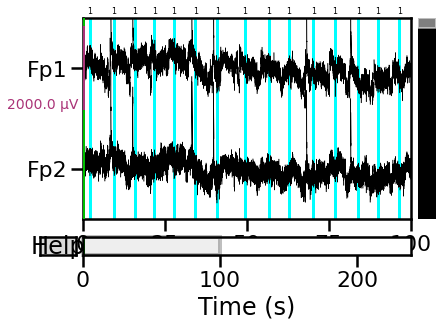

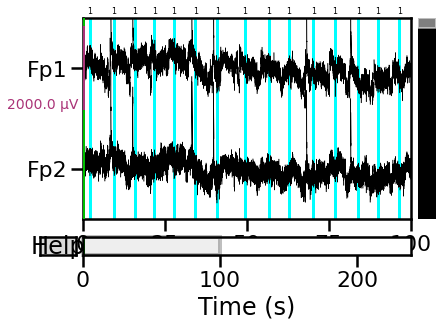

In [6]:
# testing
raw = creat_mne_raw_object("grasp-and-lift-eeg-detection/train/subj1_series1_data.csv")
# plotting 
# scaling is necessary to show the graphs properly
# vertical lines indicate a event
scalings = {'eeg': 10e-4}
events = mne.find_events(raw, stim_channel=['HandStart',])
raw.plot(n_channels=2,scalings=scalings,duration=100.0, events= events)

## Prepare the data for training and testing
Toy model: try to predict one event (in fact there are six)
    signal needs to be in correct format: nbatch x 1 x nfeutures x time tensor.
    The inputs to the models are the time series EEG signals. All channels will be
    concatnated into one channel by iSith.
    The targets are inputed separately with 1xtime dimension tensor. The target is either 0 or 1 at any time point.  
    **Dimention of the input tensors  (batch, MAGIC, features, sequence). The second "magic" dimention will always be 1 in order for this to quickly calculate the output of the SITH layer.**  
    For this model batch should be one because we only feed one trial of one subject

In [7]:
# input data, for this toy model, only consider the first 3000 unprocessed time points

## the first 6 channel are targets, for this model, only use one channel

data = raw.get_data()[:,0:3000]
input_signal = data[0:32,:]

target_signal = data[33,:] # use only the first channel target
# reformatt into tensor
input_tensor = ttype(input_signal.reshape(1,1,input_signal.shape[0],-1))


target_tensor = ttype(target_signal.reshape(1,-1))

target_tensor.shape


torch.Size([1, 3000])

In [8]:
input_tensor.shape

torch.Size([1, 1, 32, 3000])

## Functions for training and testing

In [9]:
def train_model(model, signal,target,
                optimizer,
                loss_func,
                epochs=1500):
    """
    Toy model: try to predict one event (in fact there is six)
    signal needs to be in correct format: nbatch x 1 x numFeutures x time tensor.
    The inputs to the models are the time series EEG signals. All channels will be
    concatnated into one channel by iSith.
    The targets are inputed separately with [time] dimension tensor. The target is either 0 or 1 at any time point.  
    
    """
    
    loss_track = {"val":[],
                  "epoch":[],
                  "acc":[],
                  "name":[]}

    # for GPU use torch.cuda.LongTensor
    inps = signal.type(torch.DoubleTensor)
    targets = target.type(torch.LongTensor)
    
    progress_bar = tqdm(range(int(epochs)))
    
    for e in progress_bar:
        # Zero the gradient between each batch
        model.zero_grad()
        
        # Present an entire batch to the model
        out = model(inps)
        #print(out.shape)
        # Measure loss via CrossEntropyLoss
        loss = loss_func(out, targets)
        
        # Adjust Weights
        loss.backward()
        optimizer.step()
        
        # Record loss, epoch number, batch number in epoch, 
        # last accuracy measure, etc
        loss_track['val'].append(loss.mean().detach().cpu().numpy())
        loss_track['epoch'].append(e)
        loss_track['name'].append(model.__class__.__name__)
        
        acc = test_model(model, signal,target)
        loss_track['acc'].append(acc)
        
        # Update progress_bar
        progress_bar.set_description("%i: Loss: %0.6f, Acc: %0.4f" % (e, loss_track['val'][-1], acc))
        
    return loss_track

def test_model(model, signal,target, thresh = 0.1):
    """
    Toy model: test for accuracy
    
    signal needs to be in correct format: nchannels x 1 x 1 x time tensor.
    The inputs to the models are the time series EEG signals. All channels will be
    concatnated into one channel by iSith.
    The targets are inputed separately with 1x1x1xtime dimension tensor. The target is either 0 or 1 at any time point.  
    
    """
    inps = signal.type(torch.DoubleTensor)
    targets = target.type(torch.LongTensor)
    
    out = model(inps)
    result = out[:,-1]
    # Accuracy: use a threshold (currently 0.1, subject to change)
    # if value is smaller than the threshold, 0 is assigned, and 1 is assigned otherwise

    result[result<thresh] = 0
    result[result>=thresh] = 1
    correct = (result == targets).sum().detach().cpu().numpy()
    acc = correct/targets.shape[1]
    return acc

In [10]:
class DeepSITH_Classifier(nn.Module):
    def __init__(self, out_features, layer_params, dropout=.5):
        super(DeepSITH_Classifier, self).__init__()
        last_hidden = layer_params[-1]['hidden_size']
        self.hs = DeepSITH(layer_params=layer_params, dropout=dropout)
        self.to_out = nn.Linear(last_hidden, out_features)
    def forward(self, inp):
        x = self.hs(inp)
        x = self.to_out(x)
        return x

## Setting Deep_iSith parameters and training 

In [ ]:
# num of epochs to train
epochs = 30
# Just for visualizing average loss through time. 
loss_buffer_size = 100
loss_func = torch.nn.CrossEntropyLoss()


#--------------- sith layer model parameters ------------------#
sith_params2 = {"in_features":32, # make sure this mathces the number of feutures in the EEG data
                "tau_min":.1, "tau_max":20.0, 'buff_max':40,
                "k":50,
                "ntau":10, 'g':0,  
                "ttype":ttype, 
                "hidden_size":100, "act_func":nn.ReLU()}
sith_params3 = {"in_features":sith_params2['hidden_size'], 
                "tau_min":.1, "tau_max":200.0,  'buff_max':240,
                "k":50,
                "ntau":10, 'g':0, 
                "ttype":ttype, 
                "hidden_size":100, "act_func":nn.ReLU()}
layer_params = [sith_params2, sith_params3]


#------------------ model configuration ------------------------#
# number of output feature should be the number of time points
model = DeepSITH_Classifier(out_features=target_tensor.shape[1],
                            layer_params=layer_params, 
                            dropout=0.1).double()
optimizer = torch.optim.Adam(model.parameters())

#------------------ training -----------------------------------#
perf = train_model(model, input_tensor, target_tensor,
                   optimizer, loss_func,epochs=epochs )
                   #loss_buffer_size=loss_buffer_size

## Plot training result

In [ ]:
fig = plt.figure(figsize=(15, 8))
loss = [float(x) for x in perf["val"]]
acc = [float(x) for x in perf["acc"]]
ax = fig.add_subplot(1,2,1)
sn.lineplot(data=perf, x='epoch', y=loss, hue="name",
            ax=ax)
ax.set_xlabel("Epoch Num")
ax.set_ylabel("Loss")
ax.set_title("Loss over Batches")


ax = fig.add_subplot(1,2,2)
sn.lineplot(data=perf, x='epoch', y=acc, hue="name",
            ax=ax)
ax.set_xlabel("Epoch Num")
ax.set_ylabel("Accuracy")
ax.set_title("Correct Acc over Batches")